# Addestra il tuo GPTux

Questo è un breve notebook in cui è presentata la costruzione ed addestramento di un transformer "giocattolo", sia per le sue dimensioni che per il piccolo dataset utilizzato.
Lo scopo è quindi puramente didattico, in quanto il notebook nasce come parte integrante della presentazione per l'evento organizzato dall'associazione POuL per il Linux Day 2025.



## Tokenizer


Così come i pixel con la loro rappresentazione tramite vettore 3 dimensionale (RGB), vanno a formare una rappresentazione delle immagini adatta all'elaborazione digitale; anche il testo ha bisogno di essere suddiviso in parole o sotto-parole che possano essere rappresentabili univocamente tramite un vettore multi dimensionale.

<div align="center">

$pixel : immagine = token : testo$

</div>

Un tokenizzatore fa proprio l'operazione di dividere un documento in "pixel di testo", chiamati **token** (tasselli). 

Sarà poi compito del modello capire quale vettore rappresenti al meglio ciascun token.

In [1]:
from transformers import AutoTokenizer
import transformers
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import numpy as np
import gc

# Download and initialize the tokenizer used by Pythia
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-160m')

# Show an example of tokenization
text = "this is a Tokenizer!"
tokenized_input = tokenizer(text)

print(f"Original text:    `{text}`")
print("Input IDs:       ", tokenized_input['input_ids'])
print("Tokens:          ", tokenizer.convert_ids_to_tokens(tokenized_input['input_ids']))
print("Converted back:  ", tokenizer.decode(tokenized_input['input_ids']), end="\n\n\n\n")
print("Notes:")
print(f"    - the tokenizer uses {tokenizer.vocab_size} different tokens!")
print(f"    - Some words like 'tokenizes' are split into multiple tokens: {tokenizer.tokenize('tokenizes')}!")
print("    - Characters like spaces are tokenized with special characters: ", tokenizer.tokenize(" "))
print(f"    - The token `John` is different from ` John` and `john`: {tokenizer.tokenize('John')} vs {tokenizer.tokenize(' John')} vs {tokenizer.tokenize('john')}")
print(f"    - The tokenizer uses special tokens come {tokenizer.special_tokens_map} per rappresentare inizio/fine frase, padding, parole sconosciute, ecc.")

Original text:    `this is a Tokenizer!`
Input IDs:        [2520, 310, 247, 35097, 6081, 2]
Tokens:           ['this', 'Ġis', 'Ġa', 'ĠToken', 'izer', '!']
Converted back:   this is a Tokenizer!



Notes:
    - the tokenizer uses 50254 different tokens!
    - Some words like 'tokenizes' are split into multiple tokens: ['token', 'izes']!
    - Characters like spaces are tokenized with special characters:  ['Ġ']
    - The token `John` is different from ` John` and `john`: ['John'] vs ['ĠJohn'] vs ['john']
    - The tokenizer uses special tokens come {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'} per rappresentare inizio/fine frase, padding, parole sconosciute, ecc.


## Transformer di Esempio: Pythia / GPT NeoX

Useremo questo modello come esempio, completamente open source sia lato software che lato pesi e dati. Fa parte di un progetto di ricerca promosso da [EleutherAI](https://www.eleuther.ai/).
I modelli sono basati sull'architettura [GPT-NeoX](https://github.com/EleutherAI/gpt-neox), simile a GPT-3 di OpenAI. La famiglia di modelli [Pythia](https://github.com/EleutherAI/pythia) parte dai 14 milioni di parametri fino ad arrivare a modelli con 12 miliardi di parametri. 
Noi useremo un modello molto piccolo da 160 milioni di parametri: **pythia-160m**.


In [2]:
hf_model = transformers.AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-160m')

hf_model # Show the model architecture

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
          (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwi

## Embedding and Unembedding

#### Embedding

L'operazione di embedding consiste nel mappare ogni token in un vettore di dimensione fissa, che rappresenta il token in uno spazio multi-dimensionale.
Essenzialmente associa ad ogni elemento nel vocabolario un vettore.

1. Decidiamo la **dimensionalità dello spazio** che il modello userà per rappresentare il suo ragionamento (d_model)
2. Definiamo un embedding layer, in realtà non è altro che una matrice che proietta ogni token nello spazio d_model

#### Unembedding / Language Modeling Head
( + immagine)
L'operazione di unembedding consiste nel mappare ogni vettore di dimensione fissa (d_model) in un token. Spesso questa operazione è implementata come la trasposizione della matrice di embedding. 
Essenzialmente associa un "punteggio" ad ogni token nel vocabolario, in base alla sua vicinanza al vettore nello spazio d_model.

Anche in questo caso, non è altro che una matrice che proietta ogni vettore nello spazio del vocabolario.

In [3]:
class GPTuxEmbedding(nn.Module):
    def __init__(self, vocab_size, hidden_size, weights=None):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, hidden_size)
        if weights is not None:
            self.token_emb.weight = nn.Parameter(weights)

    def forward(self, x):
        return self.token_emb(x)


class GPTuxLMH(nn.Module):
    def __init__(self, vocab_size, hidden_size, weights=None, bias=None):
        super().__init__()
        if bias is None:
            self.lm_head = nn.Linear(hidden_size, vocab_size, bias=False)
        else:
            self.lm_head = nn.Linear(hidden_size, vocab_size, bias=True)
            self.lm_head.bias = nn.Parameter(bias)
        if weights is not None:
            self.lm_head.weight = nn.Parameter(weights)

    def forward(self, x):
        return self.lm_head(x)

In [4]:
tokenized_input = tokenizer("test", return_tensors='pt')

embedding_layer = GPTuxEmbedding(vocab_size=50254, hidden_size=768, weights=hf_model.gpt_neox.embed_in.weight)
lm_head = GPTuxLMH(vocab_size=50254, hidden_size=768, weights=hf_model.embed_out.weight, bias=hf_model.embed_out.bias)
x = embedding_layer(x = tokenized_input['input_ids'])
logits = lm_head(x)

print(f"Input shape: {tokenized_input['input_ids'].shape}")
print(f"Embedding output shape: {x.shape}")
print(f"LM Head output shape: {logits.shape}")

Input shape: torch.Size([1, 1])
Embedding output shape: torch.Size([1, 1, 768])
LM Head output shape: torch.Size([1, 1, 50304])


In [5]:
# Test Embedding e LM Head
# Embedding
sample_input = tokenizer("Hello GPTux!", return_tensors='pt')['input_ids']
embedding_layer = GPTuxEmbedding(vocab_size=hf_model.config.vocab_size, hidden_size=hf_model.config.hidden_size,
                                weights=hf_model.gpt_neox.embed_in.weight)
embedded_output = embedding_layer(sample_input)
hf_embedded_output = hf_model.gpt_neox.embed_in(sample_input)
print("Embedding sono compatibili?", torch.allclose(embedded_output, hf_embedded_output, atol=1e-6))

# LM Head
lm_head = GPTuxLMH(vocab_size=hf_model.config.vocab_size, hidden_size=hf_model.config.hidden_size,
                   weights=hf_model.embed_out.weight, bias=hf_model.embed_out.bias)
lm_output = lm_head(embedded_output)
hf_lm_output = hf_model.embed_out(embedded_output)
print("LM Head sono compatibili?", torch.allclose(lm_output, hf_lm_output, atol=1e-6))


Embedding sono compatibili? True
LM Head sono compatibili? True


## Decoding

Il decoding è il processo di generazione di testo a partire dai token previsti dal modello. Esistono diversi metodi per effettuare il decoding, tra cui:
- **Greedy Decoding**: seleziona il token con la probabilità più alta ad ogni passo.
- **Beam Search**: mantiene un certo numero di sequenze candidate e seleziona la migliore alla fine.
- **Sampling**: seleziona i token in base alla loro distribuzione di probabilità, permettendo una maggiore varietà nel testo generato.
- **Top-k Sampling**: limita la selezione ai k token più probabili.

Noi useremo o il greedy decoding o un sampling basato sulla probabilità (temperature sampling).

In [6]:
tokenized_input = tokenizer("My name is Bond, James", return_tensors='pt')
logits = hf_model(**tokenized_input).logits
logits.shape  # Questo è l'output del modello: un vettore multi-dimensionale, non ancora testo

torch.Size([1, 6, 50304])

In [7]:
def greedy_decode(logits):
    logits = logits[:, -1]  # Prendiamo solo l'ultimo token predetto
    predicted_token_ids = torch.argmax(logits, dim=-1) # Prende il massimo (Greedy Decoding)
    return tokenizer.decode(predicted_token_ids[0]).replace("Ġ", "_")

print("Decoded output:", greedy_decode(logits)) 

Decoded output:  Bond


In [8]:
def plot_topk_logits(logits, tokenizer, topk=10, title="Top-k Token Probability Distribution"):
    """
    Plots the probability distribution of the top-k tokens from logits.

    Args:
        logits (torch.Tensor or np.ndarray): The logits for a single position (1D array).
        tokenizer: HuggingFace tokenizer to convert token ids to strings.
        topk (int): Number of top tokens to display.
        title (str): Title for the plot.
    """
    if isinstance(logits, torch.Tensor):
        logits = logits.detach().cpu().numpy()
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    topk_indices = probs.argsort()[-topk:][::-1]
    topk_probs = probs[topk_indices]
    topk_tokens = [s.replace("Ġ", "_") for s in tokenizer.convert_ids_to_tokens(topk_indices)]

    plt.figure(figsize=(6, 1 + 0.2 * topk))
    bars = plt.barh(range(topk), topk_probs, color='steelblue')
    plt.yticks(range(topk), topk_tokens)
    plt.xlabel("Probability")
    plt.title(title)
    plt.gca().invert_yaxis()
    for i, bar in enumerate(bars):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{topk_probs[i]:.2%}", va='center')
    plt.tight_layout()
    plt.show()

AVERAGE TEMPERATURE (0.7):


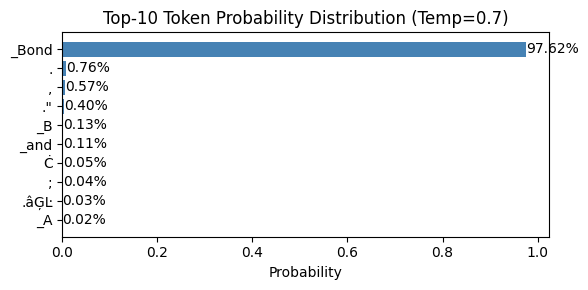


HIGH TEMPERATURE (3):


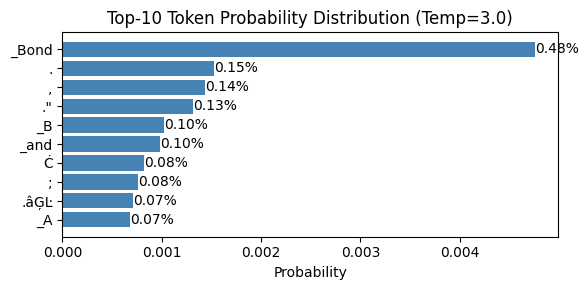


LOW TEMPERATURE (0.1):


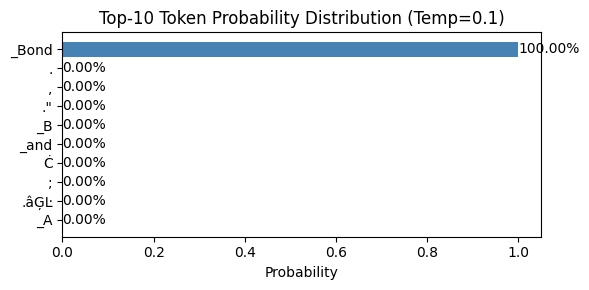

' Bond'

In [9]:
def probabilistic_decode(logits, temperature=1.0, verbose=False):
    scaled_logits = logits[:, -1] / temperature
    probabilities = torch.softmax(scaled_logits, dim=-1)
    predicted_token_id = torch.multinomial(probabilities, num_samples=1)
    if verbose:
        plot_topk_logits(scaled_logits[0], tokenizer, topk=10, title=f"Top-10 Token Probability Distribution (Temp={temperature})")
    return tokenizer.decode(predicted_token_id[0]).replace("Ġ", "_")

print("AVERAGE TEMPERATURE (0.7):")
probabilistic_decode(logits, temperature=0.7, verbose=True)

print("\nHIGH TEMPERATURE (3):")
probabilistic_decode(logits, temperature=3.0, verbose=True)

print("\nLOW TEMPERATURE (0.1):")
probabilistic_decode(logits, temperature=0.1, verbose=True)


## LayerNorm

La layer normalizzazione è il primo "componente" che troviamo in ogni blocco del transformer. Il suo scopo è quello di normalizzare l'input del layer successivo, in modo da stabilizzare e accelerare l'addestramento del modello. Non inserisce quindi particulari informazioni, semplicemente si usa per motivi di ottimizzazione.

L'operazione che compie è la seguente:
1. Calcola la media e la deviazione standard dell'input
2. Normalizza l'input sottraendo la media e dividendo per la deviazione
3. Applica una trasformazione lineare con parametri appresi (gamma e beta) (notare che questi parametri non sono strettamente necessari ma nella pratica aiutano a dare importanza a certe feature)

Matematicamente, per un input \(x\) dove x è un vettore di dimensione d_model, la LayerNorm è definita come:
$$
\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sigma} + \beta
$$

In [10]:
class GPTuxLayerNorm(nn.Module):
    def __init__(self, dim, gamma=None, beta=None, eps=1e-5):
        super().__init__()
        self.eps = eps

        self.gamma = nn.Parameter(gamma if gamma is not None else torch.ones(dim))
        self.beta = nn.Parameter(beta if beta is not None else torch.zeros(dim))

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x + self.beta



In [11]:
hf_model.gpt_neox.layers[0].input_layernorm

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

In [12]:
# Test
sample_input = torch.randn(2, 8, hf_model.config.hidden_size)
layer_norm = GPTuxLayerNorm(dim=hf_model.config.hidden_size,
                            gamma=hf_model.gpt_neox.layers[0].input_layernorm.weight,
                            beta=hf_model.gpt_neox.layers[0].input_layernorm.bias)
out = layer_norm(sample_input)
hf_out = hf_model.gpt_neox.layers[0].input_layernorm(sample_input)
print("Sono compatibili?", torch.allclose(out, hf_out, atol=1e-6))

Sono compatibili? True


Visualizziamo brevemente cosa succede all'interno di una LayerNorm:

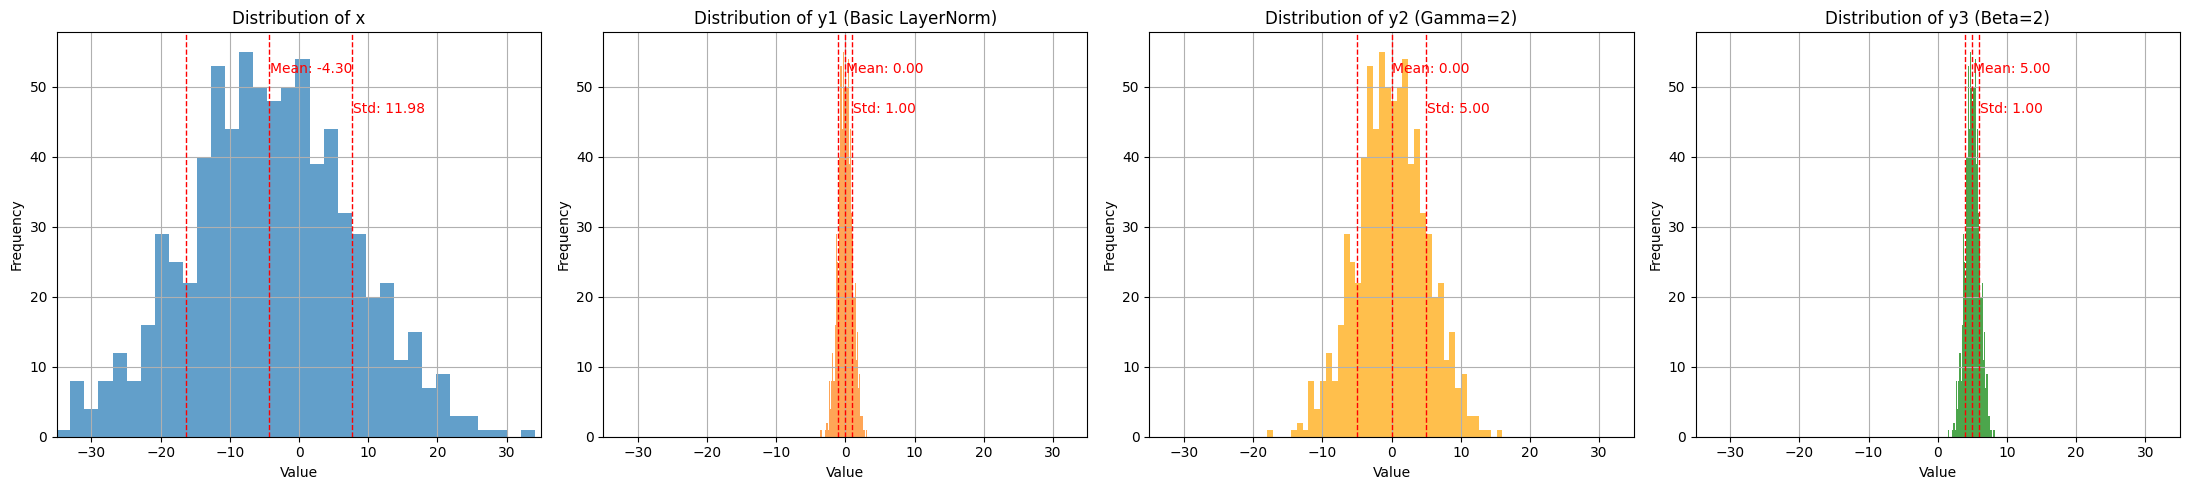

In [13]:
x = (torch.randn(768)-0.5) * 12 + 2

basic_layernorm = GPTuxLayerNorm(768)
y1 = basic_layernorm(x)

gamma_layernorm = GPTuxLayerNorm(768, gamma=5*torch.ones(768))
y2 = gamma_layernorm(x)

beta_layernorm = GPTuxLayerNorm(768, beta=5*torch.ones(768))
y3 = beta_layernorm(x)

# Plot the probability distribution (histogram) of the values in x, y1, y2, y3
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

axs[0].hist(x.detach().numpy(), bins=40, color='C0', alpha=0.7)
axs[0].set_title('Distribution of x')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)
mean = x.mean().item()
std = x.std().item()
axs[0].axvline(mean, color='red', linestyle='dashed', linewidth=1)
axs[0].axvline(mean + std, color='red', linestyle='dashed', linewidth=1)
axs[0].axvline(mean - std, color='red', linestyle='dashed', linewidth=1)
axs[0].text(mean + 0.1, axs[0].get_ylim()[1]*0.9, f'Mean: {mean:.2f}', color='red')
axs[0].text(mean + std + 0.1, axs[0].get_ylim()[1]*0.8, f'Std: {std:.2f}', color='red')


axs[1].hist(y1.detach().numpy(), bins=40, color='C1', alpha=0.7)
axs[1].set_title('Distribution of y1 (Basic LayerNorm)')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)
mean = y1.mean().item()
std = y1.std().item()
axs[1].axvline(mean, color='red', linestyle='dashed', linewidth=1)
axs[1].axvline(mean + std, color='red', linestyle='dashed', linewidth=1)
axs[1].axvline(mean - std, color='red', linestyle='dashed', linewidth=1)
axs[1].text(mean + 0.1, axs[1].get_ylim()[1]*0.9, f'Mean: {mean:.2f}', color='red')
axs[1].text(mean + std + 0.1, axs[1].get_ylim()[1]*0.8, f'Std: {std:.2f}', color='red')

axs[2].hist(y2.detach().numpy(), bins=40, color='orange', alpha=0.7)
axs[2].set_title('Distribution of y2 (Gamma=2)')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')
axs[2].grid(True)
mean = y2.mean().item()
std = y2.std().item()
axs[2].axvline(mean, color='red', linestyle='dashed', linewidth=1)
axs[2].axvline(mean + std, color='red', linestyle='dashed', linewidth=1)
axs[2].axvline(mean - std, color='red', linestyle='dashed', linewidth=1)
axs[2].text(mean + 0.1, axs[2].get_ylim()[1]*0.9, f'Mean: {mean:.2f}', color='red')
axs[2].text(mean + std + 0.1, axs[2].get_ylim()[1]*0.8, f'Std: {std:.2f}', color='red')

axs[3].hist(y3.detach().numpy(), bins=40, color='green', alpha=0.7)
axs[3].set_title('Distribution of y3 (Beta=2)')
axs[3].set_xlabel('Value')
axs[3].set_ylabel('Frequency')
axs[3].grid(True)
mean = y3.mean().item()
std = y3.std().item()
axs[3].axvline(mean, color='red', linestyle='dashed', linewidth=1)
axs[3].axvline(mean + std, color='red', linestyle='dashed', linewidth=1)
axs[3].axvline(mean - std, color='red', linestyle='dashed', linewidth=1)
axs[3].text(mean + 0.1, axs[3].get_ylim()[1]*0.9, f'Mean: {mean:.2f}', color='red')
axs[3].text(mean + std + 0.1, axs[3].get_ylim()[1]*0.8, f'Std: {std:.2f}', color='red')

for ax in axs:
    ax.set_xlim([-35, 35])

plt.tight_layout()
plt.show()

## Multi Layer Perceptron

Nell'architettuara transformer, i Multi-Layer Perceptron (MLP) vengono utilizzati all’interno di ogni blocco del transformer, subito dopo il meccanismo dell'attenzione. L’MLP è tipicamente composto da due layer lineari con una funzione di attivazione non lineare (come GELU o ReLU) tra di essi.

L’MLP aumenta la capacità del modello di rappresentare **relazioni non lineari** e in uno **spazio dimensionale superiore** affinando la rappresentazione del residuo prima di passarla al layer successivo.



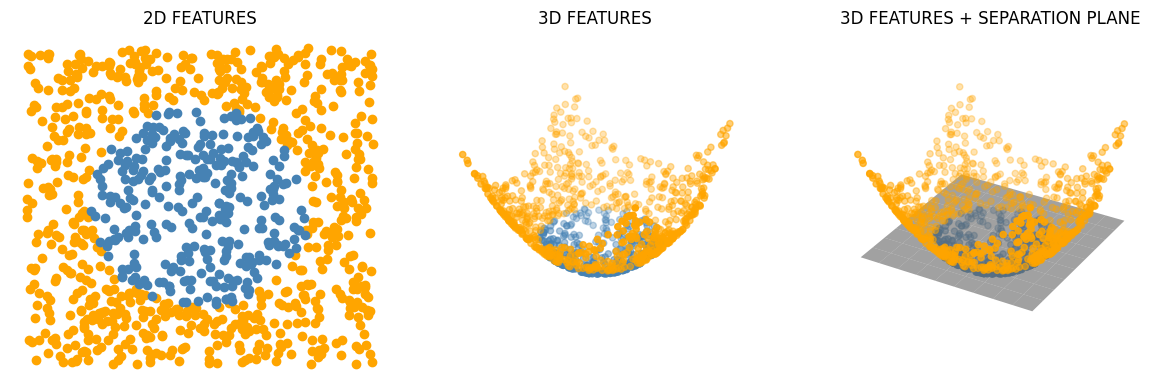

In [14]:
# Generate circle data
x = np.random.rand(1000) - 0.5
y = np.random.rand(1000) - 0.5
mask = x**2 + y**2 <= 0.1

# Add a third dimension, non linear with the other two
z = x**2 + y**2                                  # <-- THIS IS A NON-LINEAR NEW FEATURE

separation_plane = np.linspace(-0.5, 0.5, 10)
X, Y = np.meshgrid(separation_plane, separation_plane)
Z = 0.1 * np.ones_like(X)                        # <-- THIS IS A LINEAR PLANE IN X,Y,Z

fig = plt.figure(figsize=(12, 4))

# 2D scatter
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(x[~mask], y[~mask], color='orange')
ax1.scatter(x[mask], y[mask], color='steelblue')
ax1.set_title("2D FEATURES")
ax1.axis('off')

# 3D scatter
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(x[~mask], y[~mask], z[~mask], color='orange')
ax2.scatter(x[mask], y[mask], z[mask], color='steelblue')
ax2.view_init(elev=30., azim=30)
ax2.set_title("3D FEATURES")
ax2.set_axis_off()

# 3D scatter + plane
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(x[~mask], y[~mask], z[~mask], color='orange')
ax3.scatter(x[mask], y[mask], z[mask], color='steelblue')
ax3.plot_surface(X, Y, Z, alpha=0.6, color='gray')
ax3.view_init(elev=30., azim=30)
ax3.set_title("3D FEATURES + SEPARATION PLANE")
ax3.set_axis_off()

plt.tight_layout()
plt.show()

### Layer Lineari

#### Cos’è un Layer Lineare?

Un layer lineare (detto anche fully connected o denso) è uno dei mattoni fondamentali delle reti neurali. Prende un vettore di input e lo trasforma in un vettore di output moltiplicandolo per una matrice di pesi e aggiungendo un bias. Matematicamente, questa è l’operazione più semplice per esprimere una trasformazione lineare da uno spazio di input a uno spazio di output.  
Dato un vettore di input $x$, una matrice di pesi $W$ e un vettore di bias $b$, l’output $y$ si calcola come:

$$y = Wx + b$$

#### Implementazione:

In PyTorch, un layer lineare si implementa con nn.Linear(in_features, out_features). Internamente, memorizza una matrice di pesi di forma (out_features, in_features) e un vettore di bias di forma (out_features).  
Questa operazione equivale a una moltiplicazione tra matrici seguita da una somma vettoriale, che può essere eseguita con torch.einsum(), torch.nn.Linear() oppure semplicemente $y = x @ W^T + b$.

In [15]:
# Define an example input, weights, and biases
x = torch.randn(4, 10, 768)
w = torch.randn(768, 4 * 768)
b = torch.randn(4 * 768)

# Plain implementation
y_plain = x @ w + b

# Using the torch.nn module (industry standard)
linear = nn.Linear(768, 4 * 768)
linear.weight = nn.Parameter(w.T)
linear.bias = nn.Parameter(b)
y_nn = linear(x)

# Using Einstein summation notation (tensor algebra)
y_torch = torch.einsum('bsd,dh->bsh', x, w) + b # ('batch seq d_model, d_model hidden -> batch seq hidden') <-- We will use this for clarity!

assert torch.allclose(y_plain, y_nn, atol=1e-5)
assert torch.allclose(y_plain, y_torch, atol=1e-5)

### Attivazione Non Lineare

Una delle caratteristiche più importanti delle reti neurali è la capacità di modellare relazioni non lineari. Questo è reso possibile dall’uso di funzioni di attivazione non lineari, che vengono applicate dopo le trasformazioni lineari.

Essenzialmente, una funzione di attivazione introduce delle non-linearità che aumentano la capacità rappresentativa del modello. 
Senza di esse, una rete composta solo da layer lineari sarebbe equivalente a un singolo layer lineare, indipendentemente dal numero di layer (W_single = W1 @ W2 @ W3 => x @ W_single = x @ W1 @ W2 @ W3).

La scelta della funzione di attivazione è principalmente dettata da magia nera ed evidenze empiriche. Alcune delle funzioni di attivazione più comuni sono:
- ReLU (Rectified Linear Unit): $f(x) = max(0, x)$
- GELU (Gaussian Error Linear Unit): $f(x) = x * P(X \leq x)$, dove $P(X \leq x)$ è la funzione di distribuzione cumulativa della distribuzione normale standard.
- Sigmoid: $f(x) = \frac{1}{1 + e^{-x}}$
- Tanh: $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$


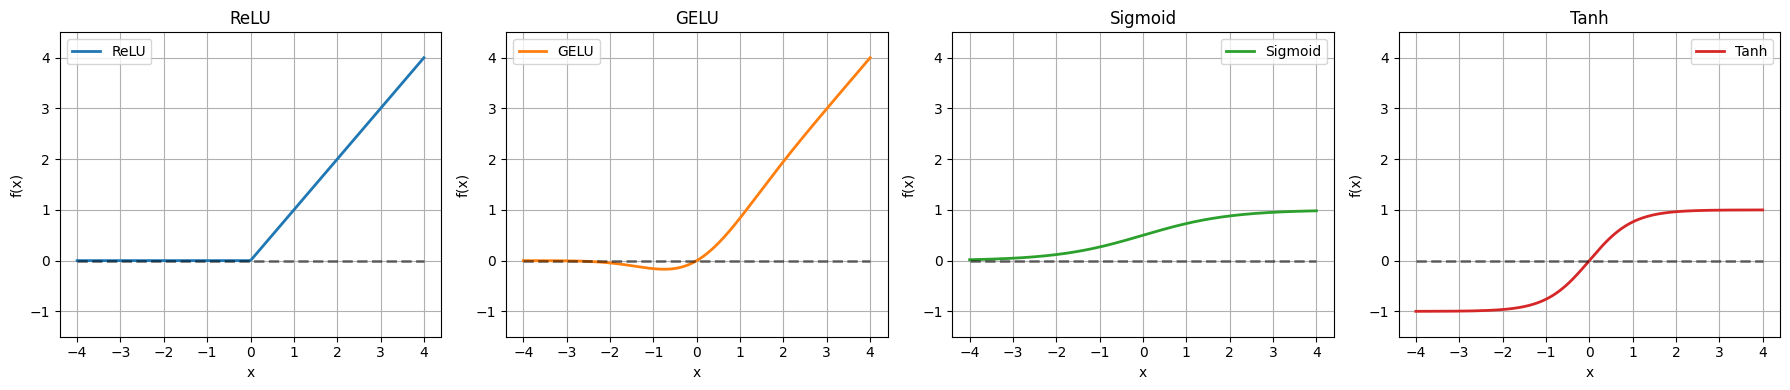

In [16]:
x = np.linspace(-4, 4, 200)
x_torch = torch.from_numpy(x)

relu = np.maximum(0, x)
gelu = torch.nn.functional.gelu(x_torch).numpy()
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))

axs[0].plot(x, relu, label='ReLU', color='C0', linewidth=2)
axs[0].set_title('ReLU')
axs[0].grid(True)

axs[1].plot(x, gelu, label='GELU', color='C1', linewidth=2)
axs[1].set_title('GELU')
axs[1].grid(True)

axs[2].plot(x, sigmoid, label='Sigmoid', color='C2', linewidth=2)
axs[2].set_title('Sigmoid')
axs[2].grid(True)

axs[3].plot(x, tanh, label='Tanh', color='C3', linewidth=2)
axs[3].set_title('Tanh')
axs[3].grid(True)

for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_ylim(-1.5, 4.5)
    ax.plot(x, x*0, color='black', linewidth=2, linestyle='--', alpha=0.5)
    ax.legend()

plt.ylim(-1.5, 4.5)
plt.tight_layout()
plt.show()

### Implementazione MLP

In [17]:
hf_model.gpt_neox.layers[0].mlp

GPTNeoXMLP(
  (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
  (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
  (act): GELUActivation()
)

In [18]:
class GPTuxMLP(nn.Module):
    def __init__(self, config, W1=None, b1=None, W2=None, b2=None, dropout=0):
        super().__init__()
        #self.dropout = nn.Dropout(dropout) # Utile se si fa training, non per l'inferenza
        self.gelu = nn.GELU()
        self.l1 = nn.Linear(config.hidden_size, 4 * config.hidden_size)
        if W1 is not None: 
            self.l1.weight = nn.Parameter(W1)
        if b1 is not None: 
            self.l1.bias = nn.Parameter(b1)
        self.l2 = nn.Linear(4 * config.hidden_size, config.hidden_size)
        if W2 is not None: 
            self.l2.weight = nn.Parameter(W2)
        if b2 is not None: 
            self.l2.bias = nn.Parameter(b2)

    def forward(self, x):
        x = self.l1(x)
        x = self.gelu(x)
        x = self.l2(x)
        #x = self.dropout(x) # Utile se si fa training, non per l'inferenza
        return x
        

In [19]:
# Test GPTuxMLP
mlp = GPTuxMLP(config=hf_model.config,
                W1=hf_model.gpt_neox.layers[0].mlp.dense_h_to_4h.weight,
                b1=hf_model.gpt_neox.layers[0].mlp.dense_h_to_4h.bias,
                W2=hf_model.gpt_neox.layers[0].mlp.dense_4h_to_h.weight,
                b2=hf_model.gpt_neox.layers[0].mlp.dense_4h_to_h.bias)

sample_input = torch.randn(2, 8, hf_model.config.hidden_size)
out = mlp(sample_input)
hf_out = hf_model.gpt_neox.layers[0].mlp(sample_input)

# Check
print("Gli output sono compatibili?", torch.allclose(out, hf_out, atol=1e-5))

Gli output sono compatibili? True


## Positional Embedding (RoPE)

(approfondimento)

Nei transformer non esiste alcuna nozione intrinseca di ordine/posizione nella frase di un token. D'altra parte, il significato di una frase dipende fortemente dall'ordine delle parole. Per esempio, "Il gatto insegue il topo" ha un significato completamente diverso da "Il topo insegue il gatto", nonostante contengano le stesse parole. Per questo motivo è **strettamente necessario** fornire al modello delle informazioni sulla posizione dei token nella sequenza. Esistono diversi metodi per incorporare queste informazioni, tra cui:
- **Positional Encoding**: Aggiunge un vettore di posizione pre-calcolato ad ogni embedding di token.
- **Learned Positional Embeddings**: Utilizza un layer di embedding separato per imparare le rappresentazioni di posizione durante l'addestramento.
- **Rotary Positional Embeddings (RoPE)**: Integra le informazioni di posizione direttamente nei meccanismi di attenzione, ruotando gli spazi di embedding in base alla posizione dei token.

### RoPE

L'idea alla base di RoPE è quella di applicare una rotazione agli spazi di embedding dei token in base alla loro posizione nella sequenza. Questo viene fatto utilizzando funzioni trigonometriche (seno e coseno) per creare una matrice di rotazione che dipende dalla posizione del token. In questo modo, le relazioni tra i token possono essere modulate in base alla loro posizione relativa, migliorando la capacità del modello di catturare le dipendenze a lungo raggio nel testo.

Matematicamente, per un token in posizione \(pos\) con embedding \(x\), la rotazione viene applicata come segue:
$$
x_{rotated} = R(pos) \cdot x
$$
dove \(R(pos)\) è la matrice di rotazione calcolata utilizzando le funzioni seno e coseno basate sulla posizione \(pos\).

Questo metodo è usato in molti modelli moderni, tra cui Pythia, Qwen, Llama etc. 

La proprietà matematica chiave di questa rotazione è che il prodotto scalare tra due vettori ruotati dipende solo dalla differenza tra le loro posizioni:
$$
    \langle R(\theta_1)\vec{v}_1, R(\theta_2)\vec{v}_2 \rangle = \langle \vec{v}_1, \vec{v}_2 \rangle \cdot \cos(\theta_1 - \theta_2)
$$
Essenzialmente il modello può **recuperare la distanza relativa tra due token** semplicemente confrontando i loro vettori ruotati. La rotazione non altera la lunghezza dei vettori, ma ne cambia la direzione in modo controllato, permettendo al meccanismo di attenzione di essere sensibile alla posizione relativa tra token.


In [20]:
class GPTuxRotaryEmbedding(torch.nn.Module):
    def __init__(self, dim: int, max_seq_len: int, base: int = 10000, precision: torch.dtype = torch.float32):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base
        
        # Calcola l'inveso delle frequenze in fp32
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.float32) / self.dim))

        # Calcola i valori di coseno e seno per tutte le posizioni fino a max_seq_len
        t = torch.arange(self.max_seq_len, dtype=torch.float32)
        freqs = torch.einsum("i,j->ij", t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)

        # Salva tali valori in una cache come attributi
        self.cos_cached = emb.cos().to(precision)
        self.sin_cached = emb.sin().to(precision)

    @staticmethod
    def _rotate_half(x: torch.Tensor) -> torch.Tensor:
        """
        Rotates half of the hidden dimensions of the input tensor.
        This is the core operation for applying the rotary embedding.
        """
        x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
        return torch.cat((-x2, x1), dim=-1)

    def forward(self, q: torch.Tensor, k: torch.Tensor, offset: int = 0) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Applies rotary positional embedding to the query and key tensors.

        Args:
            q (torch.Tensor): The query tensor. Shape: [bsz, n_heads, seq_len, head_dim]
            k (torch.Tensor): The key tensor. Shape: [bsz, n_heads, seq_len, head_dim]
            offset (int, optional): The starting position offset, used for KV caching during
                                    inference. Defaults to 0.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing the rotated query and key tensors.
        """
        seq_len = q.shape[2]

        q = q.permute(2, 0, 1, 3)
        k = k.permute(2, 0, 1, 3)

        # Ensure that the requested sequence length is within the cached limits
        if offset + seq_len > self.max_seq_len:
            raise ValueError(
                f"Sequence length {offset + seq_len} exceeds the maximum sequence length "
                f"of {self.max_seq_len} this model supports."
            )

        # Retrieve the pre-computed cos and sin values for the current sequence length
        # Slicing is done based on the offset and current sequence length
        # Reshape to [seq_len, 1, 1, dim] to be broadcastable with q and k
        cos = self.cos_cached[offset : offset + seq_len].unsqueeze(1).unsqueeze(1)
        sin = self.sin_cached[offset : offset + seq_len].unsqueeze(1).unsqueeze(1)
        
        # Apply the rotation to the query and key tensors (apply only to the first rotary_pct of dimensions)
        q_rotated = (q[..., :self.dim] * cos) + (self._rotate_half(q[..., :self.dim]) * sin)
        k_rotated = (k[..., :self.dim] * cos) + (self._rotate_half(k[..., :self.dim]) * sin)

        # Apply the rotary embedding only to the first rotary dim dimensions
        q_rotated = torch.cat((q_rotated, q[..., self.dim:]), dim=-1)
        k_rotated = torch.cat((k_rotated, k[..., self.dim:]), dim=-1)

        q_rotated = q_rotated.permute(1, 2, 0, 3)
        k_rotated = k_rotated.permute(1, 2, 0, 3)

        return q_rotated, k_rotated

## Attenzione

### Cos'è il Meccanismo di Attenzione?

L'attenzione è il cuore dei transformer. È il meccanismo che permette al modello di "concentrarsi" su quali parti della sequenza di input sono più rilevanti per ogni posizione.

**Metafora intuitiva:** Immagina di leggere una frase. Quando leggi la parola "banca", il cervello automaticamente "presta attenzione" a parole circostanti come "fiume" o "denaro" per capire il significato nel contesto. L'attenzione nel transformer funziona allo stesso modo: per ogni token, il modello calcola quanto dovrebbe "guardare" a ogni altro token della sequenza.

### Come Funziona l'Attenzione?

L'attenzione calcula tre cose per ogni token:
1. **Query (Q):** "Che cosa sto cercando?" — una rappresentazione di ciò che il token corrente vuole sapere
2. **Key (K):** "Ecco chi sono io" — una firma identificativa di ogni token nella sequenza
3. **Value (V):** "Ecco l'informazione che porto" — il contenuto effettivo di ogni token

Il processo è fondamentalmente un'operazione di **ricerca e recupero**:
- Calcoli la somiglianza tra la Query del token corrente e le Key di tutti i token (incluso se stesso)
- Questa somiglianza (attention score) ti dice quanto importante è ogni altro token
- Infine, ponderi i Values usando questi punteggi e li sommi insieme

Matematicamente, per ogni posizione, l'output è:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Dove $d_k$ è la dimensione della key (fattore di normalizzazione).

### Attenzione Causale (Causal Attention)

Nel nostro GPTux e nei modelli di linguaggio generativi, usiamo **attenzione causale**: durante la predizione del token $t$, il modello può solo "guardare" a token in posizioni $1, 2, ..., t$. **Non può vedere il futuro**. Questo è essenziale durante l'addestramento e l'inferenza per evitare leak di informazione.

### Attention Multi-Head

Una singola attenzione potrebbe non catturare tutte le relazioni interessanti. Per questo motivo, usiamo **più heads** in parallelo:
- Ogni head apprende a concentrarsi su diversi tipi di relazioni (sintattiche, semantiche, posizionali, ecc.)
- Gli output di tutte le head vengono concatenati e proiettati
- Il modello combina questi diversi "punti di vista" per una comprensione più ricca

### Implementazione Coincisa

1. Proietta l'input in Q, K, V tramite tre layer lineari
2. Calcola attention scores: $\text{scores} = \frac{QK^T}{\sqrt{d_k}}$
3. Applica la maschera causale (setta a $-\infty$ i la similitudine ai token del futuro / evita che il modello "veda" i token futuri)
4. Applica softmax per normalizzare i punteggi
5. Moltiplica per i Values e somma: $\text{output} = \text{scores} \cdot V$
6. Proietta l'output con un layer lineare

In [21]:
class GPTuxAttention(nn.Module):
    def __init__(self, config, Wqkv=None, bqkv=None, Wo=None, bo=None):
        super().__init__()
        self.n_head = config.num_attention_heads
        self.n_embd = config.hidden_size
        self.dropout = config.attention_dropout
        self.head_dim = config.hidden_size // config.num_attention_heads
        # Pythia come molti altri modelli usa Rotary Embeddings ma applicati solo a una parte dei vettori di query e key
        self.rotary_pct = config.rotary_pct

        # Layer di proiezione QKV (uniti per compatibilità con i pesi di HuggingFace / parallelizzazione)
        self.qkv_proj = nn.Linear(self.n_embd, 3 * self.n_embd)
        if Wqkv is not None: 
            self.qkv_proj.weight = nn.Parameter(Wqkv)
        if bqkv is not None: 
            self.qkv_proj.bias = nn.Parameter(bqkv)

        # Layer di proiezione in uscita
        self.Wo = nn.Linear(self.n_embd, self.n_embd)
        if Wo is not None: 
            self.Wo.weight = nn.Parameter(Wo)
        if bo is not None: 
            self.Wo.bias = nn.Parameter(bo)

        # Maschera causale per l'attenzione
        self.causal_mask = torch.tril(torch.ones(2048, 2048))

        # Rotary Embedding
        self.rotary_dim = int(self.head_dim * self.rotary_pct)
        self.rotary_emb = GPTuxRotaryEmbedding(self.rotary_dim, max_seq_len=config.max_position_embeddings)

    def forward(self, x, position_ids, show=False):
        bs, seq, d_model = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        qkv = self.qkv_proj(x)
        q, k, v = qkv.view(bs, seq, self.n_head, 3 * self.head_dim).chunk(3, dim=-1)
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        # Applica gli embedding RoPE a query e key
        q, k = self.rotary_emb(q, k, offset=position_ids[0,0].item())


        # Calcola i punteggi di attenzione usando einsum
        # (bs, n_head, seq, head_dim) @ (bs, n_head, head_dim, seq) -> (bs, n_head, seq, seq)
        z = torch.einsum('bnsh,bnth->bnst', q, k) / math.sqrt(self.head_dim)
        if show:
            self.plot_attention_matrix(z, title="Attention Scores before Causal Masking")

        # Usa la maschera causale per mascherare i punteggi di attenzione futuri
        z = z.masked_fill(self.causal_mask[:seq, :seq] == 0, float('-inf'))
        if show:
            self.plot_attention_matrix(z, title="Attention Scores after Causal Masking")

        scores = torch.softmax(z, dim=-1)
        # scores = torch.nn.functional.dropout(scores, p=self.dropout, training=self.training)
        if show:
            self.plot_attention_matrix(scores, title="Attention Weights after Softmax")

        y = torch.einsum('bnst,bnth->bsnh', scores, v).reshape(bs, seq, d_model)

        y = self.Wo(y)

        return y

    def plot_attention_matrix(self, matrix, title="Attention Matrix"):
        matrix = matrix[0, 0].detach().cpu().numpy()  # Solo primo batch/head
        plt.figure(figsize=(6, 6))
        plt.imshow(matrix, cmap='viridis')
        for (i, j), val in np.ndenumerate(matrix):
            plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if val < matrix.max()/2 else 'black', fontsize=8)
        plt.title(title)
        plt.xlabel('Key Positions')
        plt.ylabel('Query Positions')
        plt.show()



In [22]:
hf_model.gpt_neox.layers[0].attention

GPTNeoXAttention(
  (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
  (dense): Linear(in_features=768, out_features=768, bias=True)
)

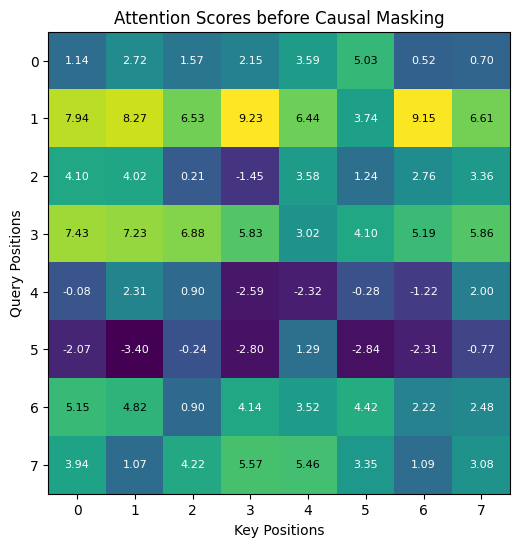

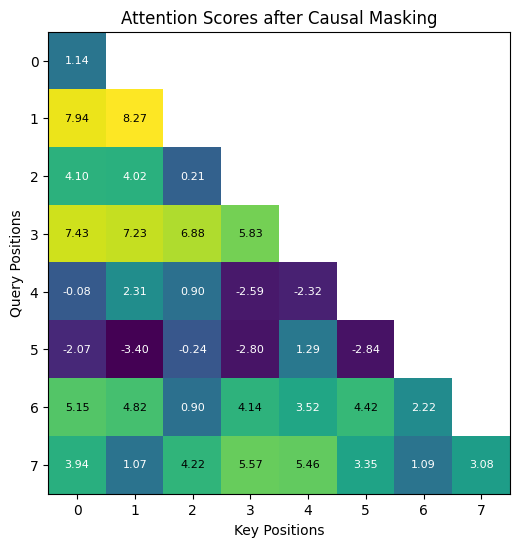

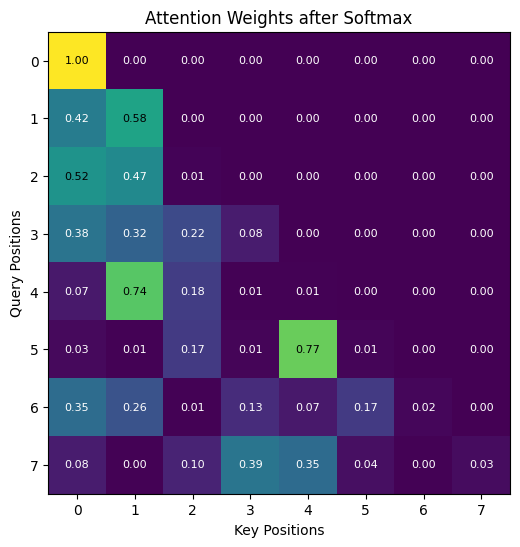

L'implementazione è compatibile? True


In [23]:
# Test GPTuxAttention
sample_input = torch.randn(2, 8, 768)  # batch size 2, sequence length 8, embedding size 768
position_ids = torch.arange(8).unsqueeze(0).repeat(2, 1)

attn = GPTuxAttention(hf_model.gpt_neox.config,
                     Wqkv=hf_model.gpt_neox.layers[0].attention.query_key_value.weight,
                     bqkv=hf_model.gpt_neox.layers[0].attention.query_key_value.bias,
                     Wo=hf_model.gpt_neox.layers[0].attention.dense.weight,
                     bo=hf_model.gpt_neox.layers[0].attention.dense.bias
                     )
out = attn(sample_input, position_ids, show=True)

# Creiamo la causal mask per il modello hf
batch_size, seq_len = sample_input.shape[:2]
causal_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool)).view(1, 1, seq_len, seq_len)
attention_mask = torch.zeros((batch_size, 1, seq_len, seq_len), dtype=sample_input.dtype)
attention_mask = attention_mask.masked_fill(causal_mask == 0, -1e9)


hf_attn_layer = hf_model.gpt_neox.layers[0].attention
# La classe GPTNeoXAttention necessita di calcolare prima i rotary embedding
position_embeddings = hf_model.gpt_neox.rotary_emb(sample_input, position_ids=position_ids)
hf_out, _ = hf_attn_layer(hidden_states=sample_input, position_embeddings=position_embeddings, attention_mask=attention_mask)

# Check
print(f"L'implementazione è compatibile? {torch.allclose(out, hf_out, atol=1e-5)}")

## Modello Completo

Il modello completo combina tutti i componenti discussi in precedenza in modo sequenziale.
Prima di tutto si trova l'Embedding layer che mappa i token in vettori di dimensione fissa. 
Successivamente, questi vettori passano attraverso una serie di blocchi transformer, ognuno composto da LayerNorm, Multi-Head Attention e MLP. 
Infine, l'output del transformer viene passato attraverso un'altra LayerNorm e un Language Modeling Head per prevedere il token successivo.


In [24]:
class GPTuxLayer(nn.Module):
    def __init__(self, config, 
                 Wqkv=None, bqkv=None, Wo=None, bo=None,
                 W1=None, b1=None, W2=None, b2=None,
                 ln1_gamma=None, ln1_beta=None,
                 ln2_gamma=None, ln2_beta=None):
        super().__init__()
        self.ln1 = GPTuxLayerNorm(config.hidden_size, gamma=ln1_gamma, beta=ln1_beta)
        self.attn = GPTuxAttention(config, Wqkv=Wqkv, bqkv=bqkv, Wo=Wo, bo=bo)
        self.ln2 = GPTuxLayerNorm(config.hidden_size, gamma=ln2_gamma, beta=ln2_beta)
        self.mlp = GPTuxMLP(config, W1=W1, b1=b1, W2=W2, b2=b2)

    def forward(self, x, position_ids):
        x = x + self.attn(self.ln1(x), position_ids) + self.mlp(self.ln2(x)) # <--- Nota: Pythia è inusuale, tipicamente attn e mlp sono applicati sequenzialmente! 
        return x

# Test GPTuxLayer
sample_input = torch.randn(2, 8, 768)  # batch size 2, sequence length 8, embedding size 768
position_ids = torch.arange(8).unsqueeze(0).repeat(2, 1)
layer = GPTuxLayer(hf_model.config,
                   Wqkv=hf_model.gpt_neox.layers[0].attention.query_key_value.weight,
                   bqkv=hf_model.gpt_neox.layers[0].attention.query_key_value.bias,
                   Wo=hf_model.gpt_neox.layers[0].attention.dense.weight,
                   bo=hf_model.gpt_neox.layers[0].attention.dense.bias,
                   W1=hf_model.gpt_neox.layers[0].mlp.dense_h_to_4h.weight,
                   b1=hf_model.gpt_neox.layers[0].mlp.dense_h_to_4h.bias,
                   W2=hf_model.gpt_neox.layers[0].mlp.dense_4h_to_h.weight,
                   b2=hf_model.gpt_neox.layers[0].mlp.dense_4h_to_h.bias,
                   ln1_gamma=hf_model.gpt_neox.layers[0].input_layernorm.weight,
                   ln1_beta=hf_model.gpt_neox.layers[0].input_layernorm.bias,
                   ln2_gamma=hf_model.gpt_neox.layers[0].post_attention_layernorm.weight,
                   ln2_beta=hf_model.gpt_neox.layers[0].post_attention_layernorm.bias
                   )
output = layer(sample_input, position_ids)
hf_layer = hf_model.gpt_neox.layers[0]
# The hf_layer expects position_embeddings to be passed, not position_ids.
# We need to calculate them first using the model's rotary embedding layer.
position_embeddings = hf_model.gpt_neox.rotary_emb(sample_input, position_ids=position_ids)
hf_output = hf_layer(sample_input, position_embeddings=position_embeddings)[0]

# Check
print("Gli output sono compatibili?", torch.allclose(output, hf_output, atol=1e-5))

Gli output sono compatibili? True


In [25]:
class GPTux(nn.Module):
    def __init__(self, config, 
                 Wqkv=None, bqkv=None, Wo=None, bo=None,
                 W1=None, b1=None, W2=None, b2=None,
                 ln1_gamma=None, ln1_beta=None,
                 ln2_gamma=None, ln2_beta=None,
                 emb_weights=None, lmh_weights=None, 
                 lmh_bias=None):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            embedding = GPTuxEmbedding(config.vocab_size, config.hidden_size, weights=emb_weights),
            layers = nn.ModuleList([GPTuxLayer(config, 
                                         Wqkv=Wqkv[i], bqkv=bqkv[i], Wo=Wo[i], bo=bo[i],
                                         W1=W1[i], b1=b1[i], W2=W2[i], b2=b2[i],
                                         ln1_gamma=ln1_gamma[i], ln1_beta=ln1_beta[i],
                                         ln2_gamma=ln2_gamma[i], ln2_beta=ln2_beta[i]) for i in range(config.num_hidden_layers)]),
            final_ln = GPTuxLayerNorm(config.hidden_size, gamma=hf_model.gpt_neox.final_layer_norm.weight, beta=hf_model.gpt_neox.final_layer_norm.bias),
            lm_head = GPTuxLMH(config.vocab_size, config.hidden_size, weights=lmh_weights, bias=lmh_bias)
        ))

    def forward(self, token_ids, position_ids):
        bs, T = token_ids.size()
        assert T <= self.config.max_position_embeddings, f"Cannot forward sequence of length {T}, block size is only {self.config.max_position_embeddings}"

        # Forward pass
        x = self.transformer.embedding(token_ids) # token embeddings of shape ( bs, seq, d_model)
        for block in self.transformer.layers:
            x = block(x, position_ids)
        
        x = self.transformer.final_ln(x)
        logits = self.transformer.lm_head(x)

        return logits

### Carichiamo i pesi nel nostro modello

Questo pugno in un occhio di codice permette di inizializzare il nostro modello prendendo i pesi dal modello di huggingface nel nostro modello.
Se tutto va bene i modelli saranno equivalenti in termini di input-output

In [26]:
our_model = GPTux(hf_model.gpt_neox.config, 
                 Wqkv=[hf_model.gpt_neox.layers[i].attention.query_key_value.weight for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 bqkv=[hf_model.gpt_neox.layers[i].attention.query_key_value.bias for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 Wo=[hf_model.gpt_neox.layers[i].attention.dense.weight for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 bo=[hf_model.gpt_neox.layers[i].attention.dense.bias for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 W1=[hf_model.gpt_neox.layers[i].mlp.dense_h_to_4h.weight for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 b1=[hf_model.gpt_neox.layers[i].mlp.dense_h_to_4h.bias for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 W2=[hf_model.gpt_neox.layers[i].mlp.dense_4h_to_h.weight for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 b2=[hf_model.gpt_neox.layers[i].mlp.dense_4h_to_h.bias for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 ln1_gamma=[hf_model.gpt_neox.layers[i].input_layernorm.weight for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 ln1_beta=[hf_model.gpt_neox.layers[i].input_layernorm.bias for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 ln2_gamma=[hf_model.gpt_neox.layers[i].post_attention_layernorm.weight for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 ln2_beta=[hf_model.gpt_neox.layers[i].post_attention_layernorm.bias for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 emb_weights=hf_model.gpt_neox.embed_in.weight,
                 lmh_weights=hf_model.embed_out.weight,
                 lmh_bias=hf_model.embed_out.bias
)

### Risultati e Decoding

In [27]:
input_ids = tokenizer("<|endoftext|>My name is Bond, James", return_tensors="pt", add_special_tokens=True).input_ids
str_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print("tokenized_input:", str_tokens)
print("Tokenized input:", str_tokens)
print("The initial special token is:", tokenizer.special_tokens_map['bos_token'], "with ID:", tokenizer.convert_tokens_to_ids(tokenizer.special_tokens_map['bos_token']))

tokenized_input: ['<|endoftext|>', 'My', 'Ġname', 'Ġis', 'ĠBond', ',', 'ĠJames']
Tokenized input: ['<|endoftext|>', 'My', 'Ġname', 'Ġis', 'ĠBond', ',', 'ĠJames']
The initial special token is: <|endoftext|> with ID: 0


La nostra implementazione di GPTux produce (quasi) gli stessi logits del modello HuggingFace GPT-NeoX!


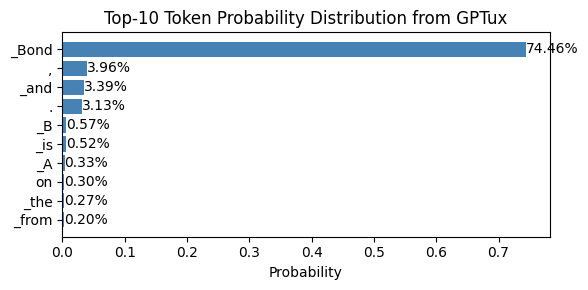

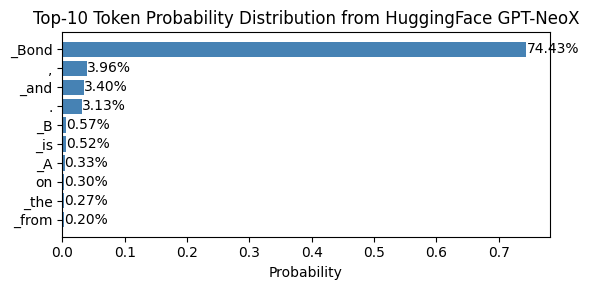

In [28]:
logits_out = our_model.forward(input_ids, position_ids=torch.tensor([[0,1,2,3,4,5]]))
# Per HuggingFace GPT-NeoX serve che position_ids abbia la stessa shape di input_ids
logits_out_hf = hf_model.forward(input_ids).logits

# Testiamo che siano "quasi" identici
assert torch.allclose(logits_out, logits_out_hf, atol=1e-5)

print("La nostra implementazione di GPTux produce (quasi) gli stessi logits del modello HuggingFace GPT-NeoX!")

plot_topk_logits(logits_out[0, -1], tokenizer, topk=10, title="Top-10 Token Probability Distribution from GPTux")
plot_topk_logits(logits_out_hf[0, -1], tokenizer, topk=10, title="Top-10 Token Probability Distribution from HuggingFace GPT-NeoX")

## Bonus: Training su un singolo esempio

Per ovvi motivi non possiamo fare un training completo di un modello in quanto richiede centinaia di ore di calcolo su GPU e dataset di almeno centinaia di Gb per ottenere risultati accettabili.

Tuttavia nulla ci vieta di fare una breve demo per vedere come un training possa funzionare.

In particolare 

In [30]:
def train_model(learning_rate, num_iterations, tokenizer, model, prompt="I use Arch btw"):
    """
    Main function to set up and run the training loop.
    """
    # Setup
    torch.manual_seed(42)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Initialize tokenizer with our specific prompt
    
    # Create training data
    # The goal is to predict the next character in the sequence.
    # For each subsequence, the model must predict the character that follows.
    all_tokens = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids[0]
    
    
    
    # Optimizer and Loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    
    print("--- Starting Training ---")
    print(f"Prompt: '{prompt}'")
    print(f"Device: {device}, LR: {learning_rate}, Iterations: {num_iterations}\n")
    
    # The Training Loop
    model.train()
    for i in range(num_iterations):
        total_loss = 0
        
        # Prepare input and target
        input_tensor = all_tokens[:-1].unsqueeze(0)
        target_tensor = all_tokens[-1].unsqueeze(0)
        
        # Core Training Steps 
        # 1. Forward pass
        logits = model(input_tensor, position_ids=torch.arange(input_tensor.shape[1]).unsqueeze(0).to(device))
        
        # 2. We only care about the prediction for the very last token
        #    in the input sequence.
        logits_last_token = logits[:, -1, :] # Shape: (batch_size, vocab_size)
        
        # 3. Calculate loss
        loss = loss_fn(logits_last_token, target_tensor)
        total_loss += loss.item()
        
        # 4. Backward pass and optimization
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        print(f"Iteration {i}/{num_iterations-1} | Average Loss: {loss.item():.4f}")

    print("\n--- Training Complete ---\n")
    
    # 6. Generation / Inference
    # Let's see what the model has learned.
    print("--- Generating Text ---")
    model.eval()
    with torch.no_grad():
        input_tensor = all_tokens[:-1].unsqueeze(0)
        target_completion = all_tokens[-1].unsqueeze(0)
        print("Input Prompt: ", tokenizer.decode(input_tensor[0]).replace("Ġ", "_"))
        print("Expected Completion: ", tokenizer.decode(target_completion).replace("Ġ", "_"))
        print("Decoding: ")
        logits = model(input_tensor, position_ids=torch.arange(input_tensor.shape[1]).unsqueeze(0).to(device))
        logits_last_token = logits[:, -1, :]
        plot_topk_logits(logits_last_token[0], tokenizer, topk=10, title="Top-10 Token Probability Distribution after Training")

In [31]:
tokenized_input = tokenizer("<|endoftext|>The best OS is Linux", return_tensors="pt", add_special_tokens=True).input_ids
str_tokens = tokenizer.convert_ids_to_tokens(tokenized_input[0])
print("Tokenized input for training:", str_tokens)
print("Tokens:", tokenized_input)

Tokenized input for training: ['<|endoftext|>', 'The', 'Ġbest', 'ĠOS', 'Ġis', 'ĠLinux']
Tokens: tensor([[    0,   510,  1682,  9485,   310, 13492]])


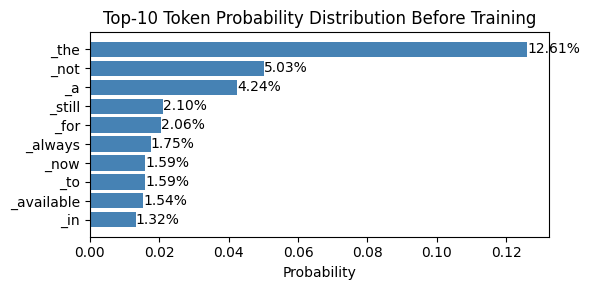

--- Starting Training ---
Prompt: '<|endoftext|>The best OS is Linux'
Device: cpu, LR: 1e-06, Iterations: 5

Iteration 0/4 | Average Loss: 5.3946
Iteration 1/4 | Average Loss: 3.9140
Iteration 2/4 | Average Loss: 2.6881
Iteration 3/4 | Average Loss: 1.8794
Iteration 4/4 | Average Loss: 1.4169

--- Training Complete ---

--- Generating Text ---
Input Prompt:  <|endoftext|>The best OS is
Expected Completion:   Linux
Decoding: 


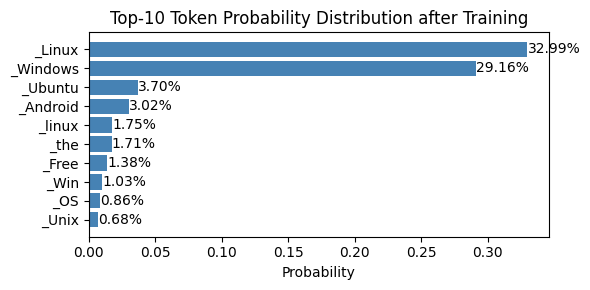

In [32]:
LEARNING_RATE = 1e-6
NUM_ITERATIONS = 5

gc.collect()
torch.cuda.empty_cache()
our_model = GPTux(hf_model.gpt_neox.config, 
                 Wqkv=[hf_model.gpt_neox.layers[i].attention.query_key_value.weight.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 bqkv=[hf_model.gpt_neox.layers[i].attention.query_key_value.bias.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 Wo=[hf_model.gpt_neox.layers[i].attention.dense.weight.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 bo=[hf_model.gpt_neox.layers[i].attention.dense.bias.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 W1=[hf_model.gpt_neox.layers[i].mlp.dense_h_to_4h.weight.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 b1=[hf_model.gpt_neox.layers[i].mlp.dense_h_to_4h.bias.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 W2=[hf_model.gpt_neox.layers[i].mlp.dense_4h_to_h.weight.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 b2=[hf_model.gpt_neox.layers[i].mlp.dense_4h_to_h.bias.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 ln1_gamma=[hf_model.gpt_neox.layers[i].input_layernorm.weight.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 ln1_beta=[hf_model.gpt_neox.layers[i].input_layernorm.bias.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 ln2_gamma=[hf_model.gpt_neox.layers[i].post_attention_layernorm.weight.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 ln2_beta=[hf_model.gpt_neox.layers[i].post_attention_layernorm.bias.detach().clone() for i in range(hf_model.gpt_neox.config.num_hidden_layers)],
                 emb_weights=hf_model.gpt_neox.embed_in.weight.detach().clone(),
                 lmh_weights=hf_model.embed_out.weight.detach().clone(),
                 lmh_bias=hf_model.embed_out.bias
)
input_ids = tokenizer("<|endoftext|>The best OS is", return_tensors="pt", add_special_tokens=True).input_ids
logits = our_model.forward(input_ids, position_ids=torch.arange(input_ids.shape[1]).unsqueeze(0))
plot_topk_logits(logits[0,-1], tokenizer, topk=10, title="Top-10 Token Probability Distribution Before Training")
train_model(learning_rate=LEARNING_RATE, num_iterations=NUM_ITERATIONS, tokenizer=tokenizer, model=our_model, prompt="<|endoftext|>The best OS is Linux")

### Nota: Non Fine Tunate così a casa!!!

Quando si fa fine tuning è importante stare attenti per non sovrascrivere le conoscenze già apprese dal modello pre-addestrato.

In generale possono succedere molte cose inaspettate, come il modello che "dimentica" tutto quello che aveva imparato prima (catastrophic forgetting) o che si adatta troppo strettamente al nuovo esempio (overfitting), perdendo la capacità di generalizzare.

Nel nostro caso il modello va ad overfittare sul singolo esempio, predicendo troppo spesso Linux anche quando è **CHIARAMENTE SBAGLIATO**.

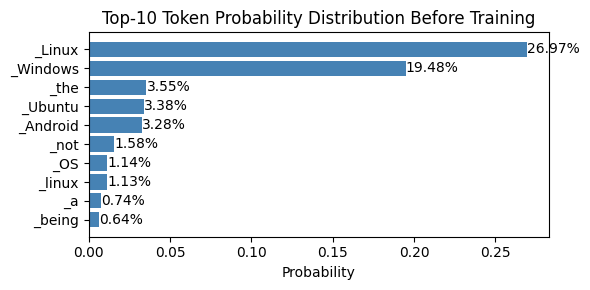

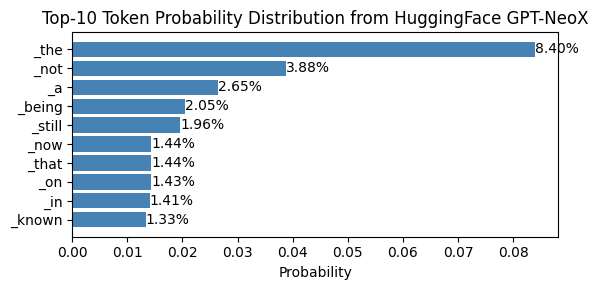

In [33]:
input_ids = tokenizer("<|endoftext|>The worst OS is", return_tensors="pt", add_special_tokens=True).input_ids
logits = our_model.forward(input_ids, position_ids=torch.arange(input_ids.shape[1]).unsqueeze(0))
plot_topk_logits(logits[0,-1], tokenizer, topk=10, title="Top-10 Token Probability Distribution Before Training")

logits_hf = hf_model.forward(input_ids).logits
plot_topk_logits(logits_hf[0,-1], tokenizer, topk=10, title="Top-10 Token Probability Distribution from HuggingFace GPT-NeoX")
